# Voting and Polling History

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-setup" data-toc-modified-id="Python-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python setup</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Historical-plots" data-toc-modified-id="Historical-plots-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Historical plots</a></span><ul class="toc-item"><li><span><a href="#Minor-parties" data-toc-modified-id="Minor-parties-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Minor parties</a></span></li><li><span><a href="#Mainstream-parties" data-toc-modified-id="Mainstream-parties-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Mainstream parties</a></span></li><li><span><a href="#Election-cycles" data-toc-modified-id="Election-cycles-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Election cycles</a></span></li></ul></li><li><span><a href="#Polling-history" data-toc-modified-id="Polling-history-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Polling history</a></span><ul class="toc-item"><li><span><a href="#Overview-of-past-elections" data-toc-modified-id="Overview-of-past-elections-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Overview of past elections</a></span></li><li><span><a href="#Individual-elections" data-toc-modified-id="Individual-elections-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Individual elections</a></span></li></ul></li><li><span><a href="#Simple-Bayesian-analysis-of-polling-errors-since-1983-(inc.)" data-toc-modified-id="Simple-Bayesian-analysis-of-polling-errors-since-1983-(inc.)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Simple Bayesian analysis of polling errors since 1983 (inc.)</a></span><ul class="toc-item"><li><span><a href="#Get-the-data-we-want-to-look-at" data-toc-modified-id="Get-the-data-we-want-to-look-at-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Get the data we want to look at</a></span></li><li><span><a href="#Quick-look-at-the-distribution-of-errors" data-toc-modified-id="Quick-look-at-the-distribution-of-errors-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Quick look at the distribution of errors</a></span></li><li><span><a href="#Build-and-run-a-Bayesian-model-using-Student's-t-distribution" data-toc-modified-id="Build-and-run-a-Bayesian-model-using-Student's-t-distribution-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Build and run a Bayesian model using Student's t-distribution</a></span></li><li><span><a href="#Extract-hyper_nu" data-toc-modified-id="Extract-hyper_nu-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Extract hyper_nu</a></span></li></ul></li><li><span><a href="#Watermark" data-toc-modified-id="Watermark-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Watermark</a></span></li></ul></div>

## Python setup

In [1]:
# data science imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Bayesian modelling ...
import pymc as pm
import arviz as az

# system imports
from io import StringIO
import pathlib

# local imports
import common
from common import COLOR_COALITION, COLOR_LABOR

In [2]:
# plotting stuff
plt.style.use('./markgraph.mplstyle')

## Data

In [3]:
data = """
Year    Date         ALP     LP      LNP  NP      CLP  DLP  DEM     GRN     ON   Others GovtBefore GovtAfter Labor2pp
1946    28-Sep-1946  49.7    33.0    -    10.7    -    -    -       -       -    6.6    Labor      Labor     54.1
1949    10-Dec-1949  46.0    39.3    -    10.8    -    -    -       -       -    3.9    Labor      Coalition 49.0
1951    28-Apr-1951  47.7    40.5    -    9.7     -    -    -       -       -    2.1    Coalition  Coalition 49.3
1954    29-May-1954  50.1    38.5    -    8.5     -    -    -       -       -    2.9    Coalition  Coalition 50.7
1955    10-Dec-1955  44.7    39.7    -    7.9     -    5.1  -       -       -    2.6    Coalition  Coalition 45.8
1958    22-Nov-1958  42.9    37.1    -    9.3     -    9.4  -       -       -    1.3    Coalition  Coalition 45.9
1961    09-Dec-1961  48.0    33.5    -    8.5     -    8.7  -       -       -    1.4    Coalition  Coalition 50.5
1963    30-Nov-1963  45.5    37.1    -    8.9     -    7.4  -       -       -    1.0    Coalition  Coalition 47.4
1966    26-Nov-1966  40.0    40.1    -    9.8     -    7.3  -       -       -    2.7    Coalition  Coalition 43.1
1969    25-Oct-1969  47.0    34.8    -    8.6     -    6.0  -       -       -    3.7    Coalition  Coalition 50.2
1972    02-Dec-1972  49.6    32.0    -    9.4     -    5.2  -       -       -    3.7    Coalition  Labor     52.7
1974    18-May-1974  49.3    34.9    -    10.8    -    1.4  -       -       -    3.5    Labor      Labor     51.7
1975    13-Dec-1975  42.8    41.8    -    11.0    0.2  1.3  -       -       -    2.8    Labor      Coalition 44.3
1977    10-Dec-1977  39.6    38.1    -    9.8     0.2  1.4  9.4     -       -    1.4    Coalition  Coalition 45.4
1980    18-Oct-1980  45.1    37.4    -    8.6     0.2  0.3  6.6     -       -    1.7    Coalition  Coalition 49.6
1983    05-Mar-1983  49.5    34.4    -    9.0     0.2  0.2  5.0     -       -    1.7    Coalition  Labor     53.2
1984    01-Dec-1984  47.5    34.1    -    10.6    0.3  0.6  5.4     -       -    1.4    Labor      Labor     51.8
1987    11-Jul-1987  45.8    34.3    -    11.5    0.2  -    6.0     -       -    2.0    Labor      Labor     50.8
1990    24-Mar-1990  39.4    34.8    -    8.4     0.3  -    11.3    1.4     -    4.4    Labor      Labor     49.9
1993    13-Mar-1993  44.9    36.8    -    7.2     0.3  -    3.8     1.9     -    5.2    Labor      Labor     51.4
1996    02-Mar-1996  38.8    38.7    -    8.2     0.4  -    6.8     2.9     -    4.3    Labor      Coalition 46.4
1998    03-Oct-1998  40.1    33.9    -    5.3     0.3  -    5.1     2.6     8.4  4.2    Coalition  Coalition 51.0
2001    10-Nov-2001  37.8    37.1    -    5.6     0.3  -    5.4     5.0     4.3  4.4    Coalition  Coalition 49.0
2004    09-Oct-2004  37.6    40.5    -    5.9     0.3  -    1.2     7.2     1.2  6.0    Coalition  Coalition 47.3
2007    24-Nov-2007  43.4    36.3    -    5.5     0.3  -    0.7     7.8     0.3  5.8    Coalition  Labor     52.7
2010    21-Aug-2010  38.0    30.5    9.1  3.7     0.3  -    0.2     11.8    0.2  6.2    Labor      Labor     50.1
2013    07-Sep-2013  33.4    32.0    8.9  4.3     0.3  0.3  -       8.6     0.2  11.9   Labor      Coalition 46.5
2016    02-Jul-2016  34.7    28.7    8.5  4.6     0.2  -    -       10.2    1.3  11.7   Coalition  Coalition 49.6
2019    18-May-2019  33.34   27.99   8.67 4.51    0.27 -    -       10.40   3.08 11.74  Coalition  Coalition 48.5
"""
# https://en.wikipedia.org/wiki/Two-party-preferred_vote
# https://www.aph.gov.au/About_Parliament/Parliamentary_Departments/Parliamentary_Library/pubs/rp/rp1617/FederalElectionResults


In [4]:
table = pd.read_csv(StringIO(data), header=0, index_col=0, 
                    skipinitialspace=True, sep=' ', na_values='-',
                    parse_dates=['Date'])
table

,Date,ALP,LP,LNP,NP,CLP,DLP,DEM,GRN,ON,Others,GovtBefore,GovtAfter,Labor2pp
Year,,,,,,,,,,,,,,
1946,1946-09-28,49.70,33.00,NaN,10.70,NaN,NaN,NaN,NaN,NaN,6.60,Labor,Labor,54.1
1949,1949-12-10,46.00,39.30,NaN,10.80,NaN,NaN,NaN,NaN,NaN,3.90,Labor,Coalition,49.0
1951,1951-04-28,47.70,40.50,NaN,9.70,NaN,NaN,NaN,NaN,NaN,2.10,Coalition,Coalition,49.3
1954,1954-05-29,50.10,38.50,NaN,8.50,NaN,NaN,NaN,NaN,NaN,2.90,Coalition,Coalition,50.7
1955,1955-12-10,44.70,39.70,NaN,7.90,NaN,5.1,NaN,NaN,NaN,2.60,Coalition,Coalition,45.8
1958,1958-11-22,42.90,37.10,NaN,9.30,NaN,9.4,NaN,NaN,NaN,1.30,Coalition,Coalition,45.9
1961,1961-12-09,48.00,33.50,NaN,8.50,NaN,8.7,NaN,NaN,NaN,1.40,Coalition,Coalition,50.5
1963,1963-11-30,45.50,37.10,NaN,8.90,NaN,7.4,NaN,NaN,NaN,1.00,Coalition,Coalition,47.4
1966,1966-11-26,40.00,40.10,NaN,9.80,NaN,7.3,NaN,NaN,NaN,2.70,Coalition,Coalition,43.1


In [5]:
coalition = ['LP', 'LNP', 'NP', 'CLP']
others = ['DLP', 'DEM', 'GRN', 'ON', 'Others']
primary = ['ALP', 'LP', 'LNP', 'NP', 'CLP', 'DLP', 'DEM', 'GRN', 'ON', 'Others']

In [6]:
# quick data consistency checks
assert(table.index.is_monotonic_increasing)
row_sums = table[primary].sum(axis=1, skipna=True)
assert((row_sums >= 99.8).all() and (row_sums <= 100.2).all())
assert((table['ALP'] < table['Labor2pp']).all())
assert(len(table['GovtBefore'].unique()) == 2)
assert(len(table['GovtAfter'].unique()) == 2)
assert((table['Date'].dt.year == table.index).all())

## Historical plots

### Minor parties

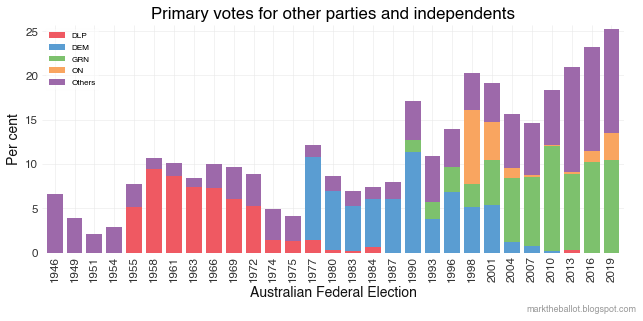

In [7]:
fig, ax = common.initiate_plot()
table[others].plot.bar(stacked=True, ax=ax, width=0.8)
common.plot_finalise(ax, title='Primary votes for other parties and independents', 
              xlabel="Australian Federal Election", ylabel='Per cent', lfooter=None)

### Mainstream parties

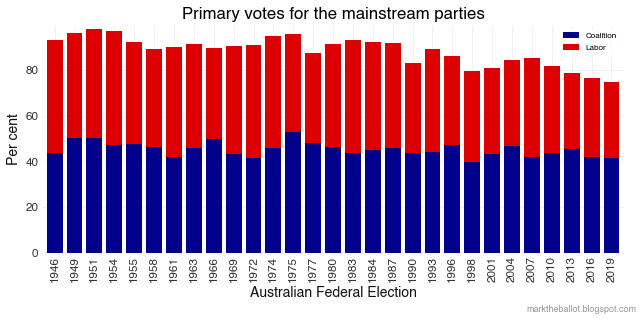

In [8]:
mainstream = table.copy()
mainstream['Coalition'] = mainstream[coalition].sum(axis=1)
mainstream = mainstream.rename(columns={'ALP': 'Labor'})
majors = ['Coalition', 'Labor']
fig, ax = common.initiate_plot()
mainstream[majors].plot.bar(stacked=True, ax=ax, width=0.8, 
                       color=[COLOR_COALITION, COLOR_LABOR])
common.plot_finalise(ax, title='Primary votes for the mainstream parties', 
              xlabel="Australian Federal Election", ylabel='Per cent', lfooter=None)

### Election cycles

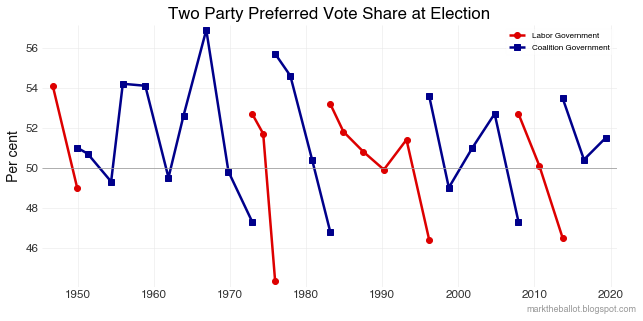

In [9]:
# identify changes of government at an election ...
changes = table['GovtBefore'] != table['GovtAfter']
change_points = changes[changes].index.values
final = table.index[-1]
if final not in change_points:
    change_points = np.append(change_points, table.index[-1])

# construct separate runs for each multi-term government
MARKER_LABOR, MARKER_COALITION = 'o', 's'
cycles = pd.DataFrame(index=table.Date)
colors = {}
markers = {}
start = table.index[0]
for i, ending in enumerate(change_points):
    name = f'{start}-{ending}'
    selection = table.index[(table.index >= start) 
                            & (table.index <= ending)]
    dates = table.loc[selection].Date
    values = table.loc[selection].Labor2pp
    if table.loc[start, 'GovtAfter'] == "Coalition":
        values = 100 - values
        colors[name] = COLOR_COALITION
        markers[name] = MARKER_COALITION
    else:
        colors[name] = COLOR_LABOR
        markers[name] = MARKER_LABOR
    values.index = dates
    cycles[name] = values
    start = ending

# plot
LW = 2.5
fig, ax = common.initiate_plot()
for column in cycles.columns:
    cycles[column].plot.line(ax=ax, marker=markers[column], 
                             c=colors[column], linewidth=LW)

# reference line
ax.axhline(y=50, color='#999999', linestyle='-', linewidth=0.75)

# custom legend
custom_lines = [
    Line2D([0], [0], color=COLOR_LABOR, lw=LW, marker=MARKER_LABOR),
    Line2D([0], [0], color=COLOR_COALITION, lw=LW, marker=MARKER_COALITION)
]
ax.legend(custom_lines, ['Labor Government', 'Coalition Government'])

# finalise plot
common.plot_finalise(ax, xlabel=None, ylabel='Per cent', lfooter=None,
                     title='Two Party Preferred Vote Share at Election',
                     concise_dates=True, straighten_tl=True)

## Polling history

In [10]:
# Historical polling data from Ethan at https://armariuminterreta.com/
historical = pd.read_excel('../historical-data/Australian Federal Polling Database.xlsx',)
len(historical)

3252

In [11]:
# quick peak at the polling data (if needed)
if False:
    display(historical.head())
    print(historical.dtypes)

In [12]:
# Get election data
# We will focus on polls in the last N Weeks of the campaign
elections = table[['Date', 'Labor2pp']].copy()
elections['Coalition2pp'] = 100.0 - elections['Labor2pp']
len(elections)

29

In [13]:
# some useful constants
COALITION_TPP = 'Est2pp'
ELECTION_MARKER = 's'
POLL_MARKER = 'o'
ELECTION_COLOR = 'darkorange'
data_statement = (
    'Data from Ethan at https://armariuminterreta.com/ '
    '(with input from William Bowe and Kevin Bonham); '
    '2pp from primary votes.'
)
SUMMARY_FOCUS = 5 # WEEKS
SUMMARY_START = pd.Timestamp('1972-01-01')


### Overview of past elections

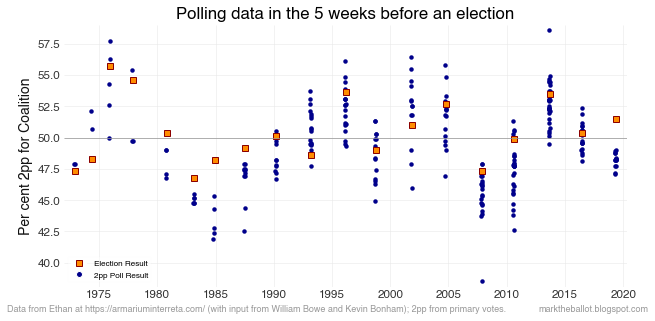

In [14]:
# plot the poll data prior to an election
fig, ax = common.initiate_plot()
for election_day in elections.Date:

    # ignore early polls
    if election_day < SUMMARY_START:
        continue
    
    # get polling data
    focus_days = SUMMARY_FOCUS * 7 # days
    election_2pp = elections.at[election_day.year, 'Coalition2pp']
    start = election_day - pd.Timedelta(days=focus_days)
    selected = historical[(historical.StartDate >= start)
                          & (historical.EndDate <= election_day)].copy()

    # --- add to the summary plot
    # polling
    selected.plot(kind='scatter', x='EndDate', y=COALITION_TPP, ax=ax, 
                  c=COLOR_COALITION, marker=POLL_MARKER)
    
    # election
    ax.plot([election_day], [election_2pp],
            c=ELECTION_COLOR, markeredgecolor='darkred', marker=ELECTION_MARKER)
    

# legend
legend_body = [Line2D([0], [0], marker=ELECTION_MARKER, color='w', label='Election Result',
                          markerfacecolor=ELECTION_COLOR, markeredgecolor='darkred', ),
              Line2D([0], [0], marker=POLL_MARKER, color='w', label='2pp Poll Result',
                          markerfacecolor=COLOR_COALITION)]
ax.legend(handles=legend_body, loc='best')

# reference line
ax.axhline(y=50, color='#999999', linestyle='-', linewidth=0.75)

# finalise
common.plot_finalise(ax, xlabel=None, ylabel='Per cent 2pp for Coalition', 
                     lfooter= data_statement,
                     title=f'Polling data in the {SUMMARY_FOCUS} '
                           'weeks before an election',
                     concise_dates=True, straighten_tl=True)

### Individual elections

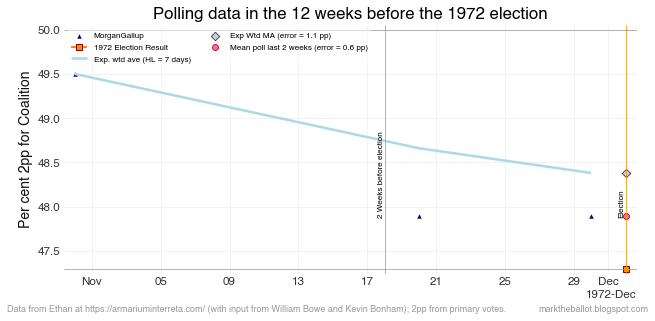

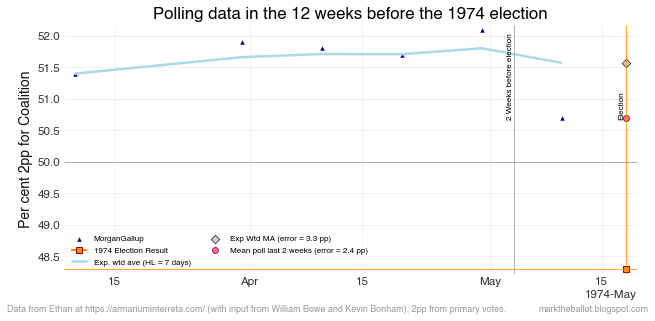

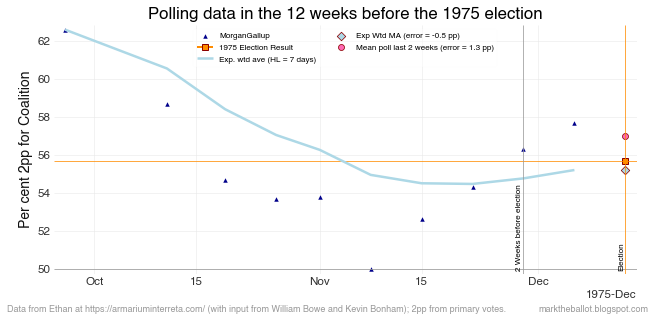

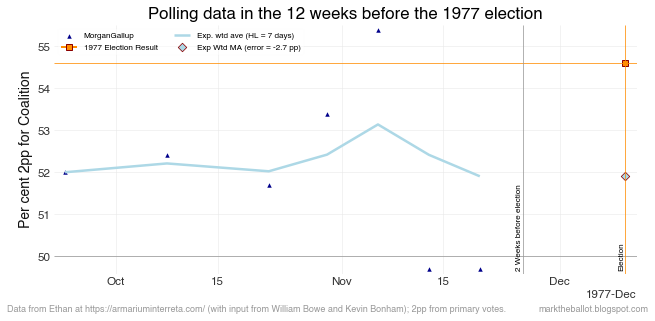

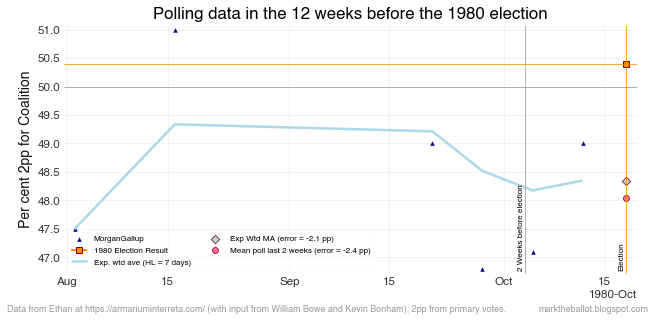

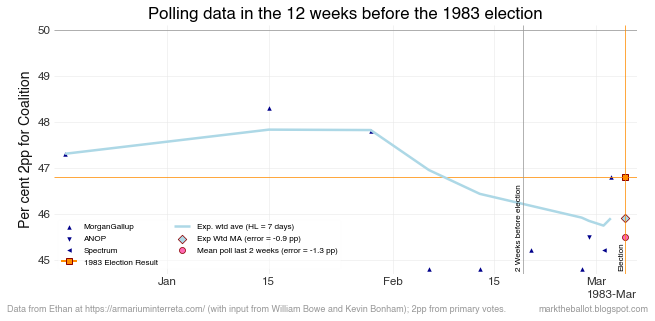

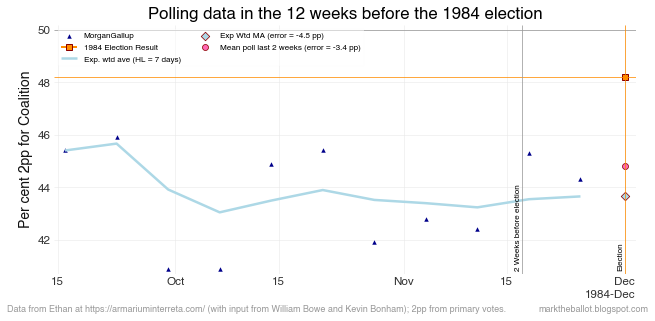

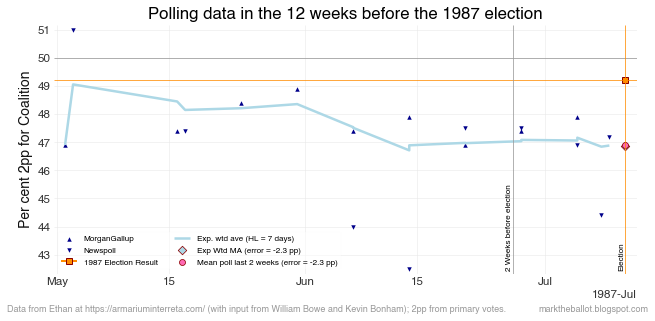

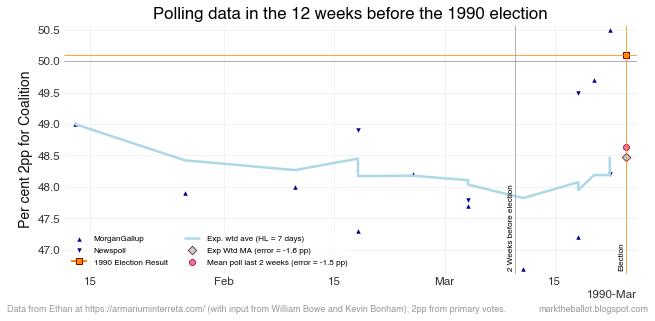

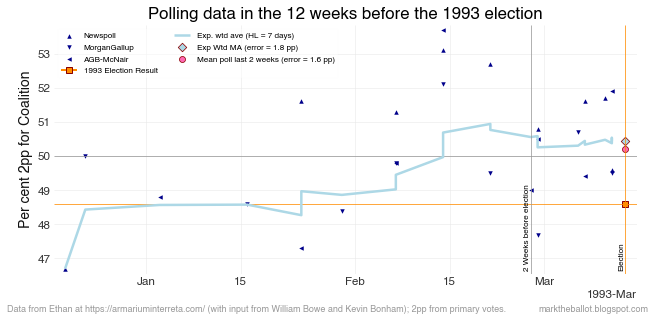

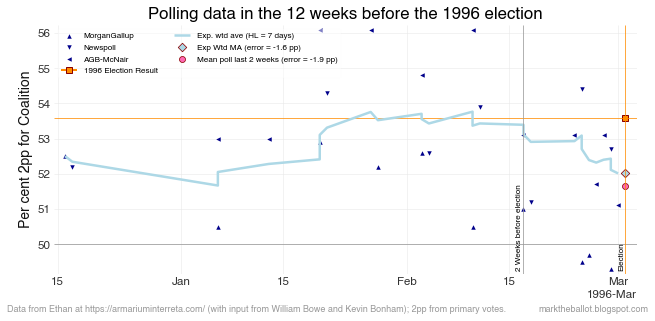

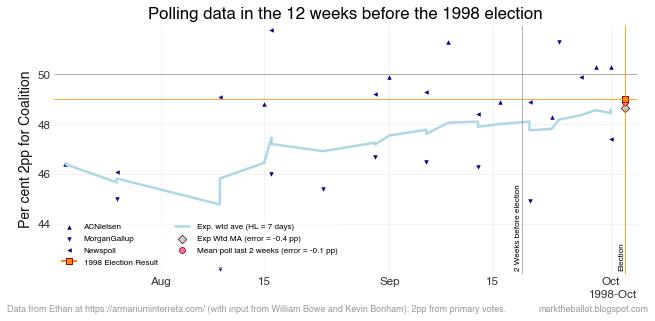

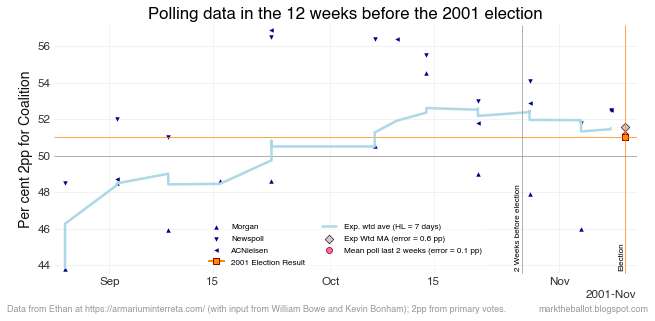

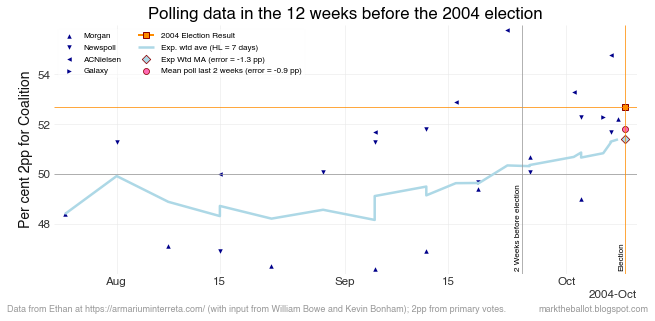

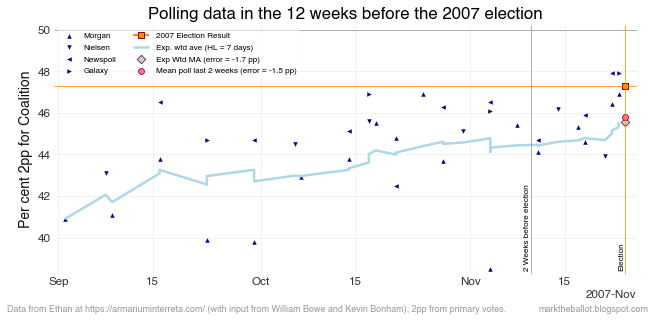

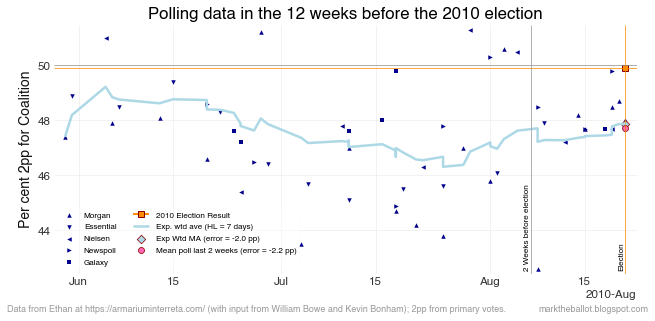

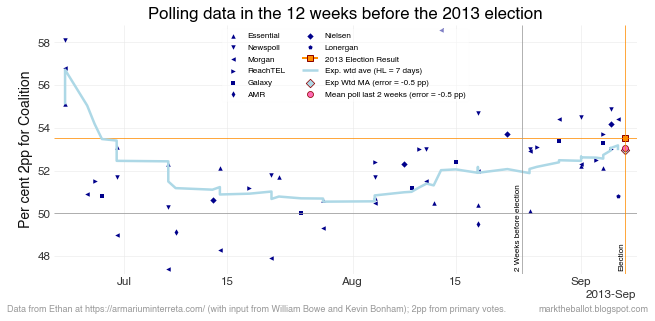

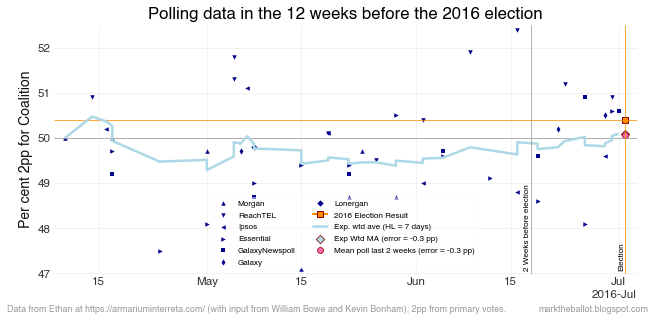

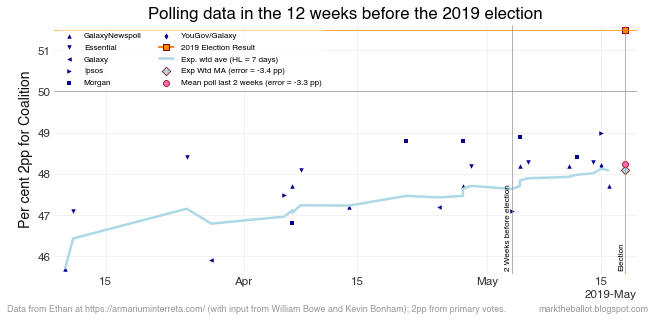

In [15]:
# --- constants
INDIV_FOCUS = 12 # weeks
HALF_LIFE = 7 # days
EWM_MARKER = 'D'
EWM_COLOR = 'lightblue'
FINAL_WEEKS = 2 # weeks - immediate prior to election

START_ANALYSIS = pd.Timestamp('1972-01-01')
# Note: no polls in final two weeks of 1977 election

MEAN_COLOR = 'hotpink'
MEAN_MARKER = 'o'

MARKERS = '^v<>sdDph'

# --- calculate and plot
ewm_errors = {}
final_errors = {}
for election in elections.Date:
    
    # ignore early polls
    if election < START_ANALYSIS:
        continue

    # get election date and outcome
    election_2pp = elections.at[election.year, 'Coalition2pp']
    final_weeks = election - pd.Timedelta(days=FINAL_WEEKS * 7)

    # get polling data
    focus_days = INDIV_FOCUS * 7 # days
    
    # get polling data
    start = election - pd.Timedelta(days=focus_days)
    selected = historical[(historical.StartDate >= start)
                          & (historical.EndDate <= election)].copy()

    # plot
    _, ax1 = common.initiate_plot()
    for i, pollster in enumerate(selected.Pollster.unique()):
        # poll data
        p_data = selected[selected.Pollster == pollster]
        p_data.plot(kind='scatter', x='EndDate', y=COALITION_TPP, ax=ax1, 
                          c=COLOR_COALITION, label=pollster, marker=MARKERS[i])
    
    ax1.plot([election], [election_2pp],
             c=ELECTION_COLOR, markeredgecolor='darkred', marker=ELECTION_MARKER,
             label=f'{election.year} Election Result')
    
    # Mark in reference line (50%) and election 2pp
    ax1.axhline(y=50, color='#999999', linestyle='-', linewidth=0.75)
    ax1.axhline(y=election_2pp, color=ELECTION_COLOR, linestyle='-', linewidth=0.75,)
    ax1.axvline(x=election, color=ELECTION_COLOR, linestyle='-', linewidth=0.75,)
    ax1.text(election, selected[COALITION_TPP].min(), 'Election', 
             rotation=90, ha='right', size='xx-small')
   
    # calculate chart the exponentially weighted moving average
    ewm = selected[COALITION_TPP].ewm(halflife=HALF_LIFE).mean()
    ewm.index = selected['EndDate']
    ewm_final = ewm.iloc[-1]
    ewm_error = ewm_final - election_2pp
    ewm_errors[election.year] = ewm_error
    ewm.plot(color=EWM_COLOR, ax=ax1, linewidth=2.5, 
             label=f'Exp. wtd ave (HL = {HALF_LIFE} days)')
    ax1.scatter([election], [ewm_final], linewidths=0.75, 
                c=EWM_COLOR, edgecolors='darkred', marker=EWM_MARKER, 
                label=f'Exp Wtd MA (error = {ewm_error:0.1f} pp)')
        
    # mark final weeks before election
    ax1.axvline(x=final_weeks, color='#999999', linestyle='-', linewidth=0.75,)
    ax1.text(final_weeks, selected[COALITION_TPP].min(), f'{FINAL_WEEKS} Weeks before election', 
             rotation=90, ha='right', size='xx-small')
    
    # average of polls for the final weeks prior to an election
    final_weeks_ave = selected.loc[selected.EndDate >= final_weeks, COALITION_TPP].mean()
    if not np.isnan(final_weeks_ave):
        final_weeks_error = final_weeks_ave - election_2pp
        final_errors[election.year] = final_weeks_error
        ax1.scatter([election], [final_weeks_ave], linewidths=0.75, 
                     c=MEAN_COLOR, edgecolors='darkred', marker=MEAN_MARKER, 
                     label='Mean poll last 2 weeks (error = '
                           f'{final_weeks_error:0.1f} pp)')
    
    # finalise the plot
    ax1.legend(loc='best', ncol=2)
    common.plot_finalise(ax1, xlabel=None, ylabel='Per cent 2pp for Coalition', 
                         lfooter=data_statement,
                         title=f'Polling data in the {INDIV_FOCUS} weeks '
                               f'before the {election.year} election',
                         concise_dates=True, straighten_tl=True)



## Simple Bayesian analysis of polling errors since 1983 (inc.)

Lets assume that polling errors are distributed by Student's t-distribution.

Then find the Student's t-distribution that best defines the distribution of polls compared with elections

### Get the data we want to look at

In [16]:
# convert above error data to a Series
# only keep error data from 1983; 
# as earlier polling is sparse and
# often just one pollster in the field.

KEEP_FROM = 1983
def retain(x: pd.Series) -> pd.Series: 
    return x[x.index >= KEEP_FROM]
s_ewm_errors = pd.Series(ewm_errors).pipe(retain)
s_final_errors = pd.Series(final_errors).pipe(retain)
s_final_errors

1983   -1.300000
1984   -3.400000
1987   -2.316667
1990   -1.466667
1993    1.618182
1996   -1.941667
1998   -0.087500
2001    0.100000
2004   -0.877778
2007   -1.500000
2010   -2.192308
2013   -0.455556
2016   -0.327273
2019   -3.270000
dtype: float64

### Quick look at the distribution of errors

In [17]:
# Quick report on mean polling error across elections
# +ve is pro-Coalition; -ve is pro-Labor
# Initial Observation: 
# It appears that polls have been historically
# biased to Labor on average
print('Mean EWM polling error across elections: '
      f'{s_ewm_errors.mean():0.4f}')
print(f'Mean final {FINAL_WEEKS}-week polling error across '
      f'elections: {s_final_errors.mean():0.4f}')

Mean EWM polling error across elections: -1.3073
Mean final 2-week polling error across elections: -1.2441


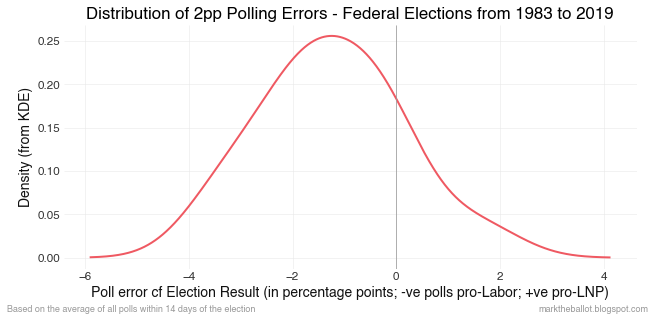

In [18]:
# kernel density estimate
ax = s_final_errors.plot.kde()
ax.axvline(x=0, color='#999999', lw=0.75)
common.plot_finalise(ax, 
                     xlabel='Poll error cf Election Result (in percentage points; -ve polls pro-Labor; +ve pro-LNP)', 
                     ylabel='Density (from KDE)',
                     lfooter='Based on the average of all polls within 14 days of the election',
                     title='Distribution of 2pp Polling Errors - Federal Elections from 1983 to 2019')

### Build and run a Bayesian model using Student's t-distribution

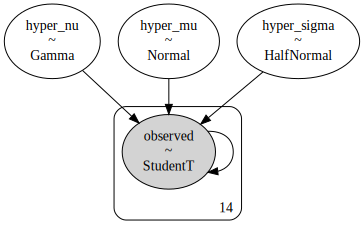

In [19]:
# construct our Bayesian model
model = pm.Model()
with model:
    hyper_mu = pm.Normal('hyper_mu', mu=0, sigma=10) # expect mode of -1 to -2 (from KDE above)
    hyper_sigma = pm.HalfNormal('hyper_sigma', sigma=10) # expect in range 1 to 2 (from KDE above)
    hyper_nu = pm.Gamma('hyper_nu', alpha=2, beta=0.1) # hard to day what I expect here
    
    observed = pm.StudentT("observed", nu=hyper_nu,
                           mu=hyper_mu, sigma=hyper_sigma,
                           observed=s_final_errors)
    
pm.model_to_graphviz(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [hyper_mu, hyper_sigma, hyper_nu]


Sampling 10 chains for 2_500 tune and 10_000 draw iterations (25_000 + 100_000 draws total) took 27 seconds.


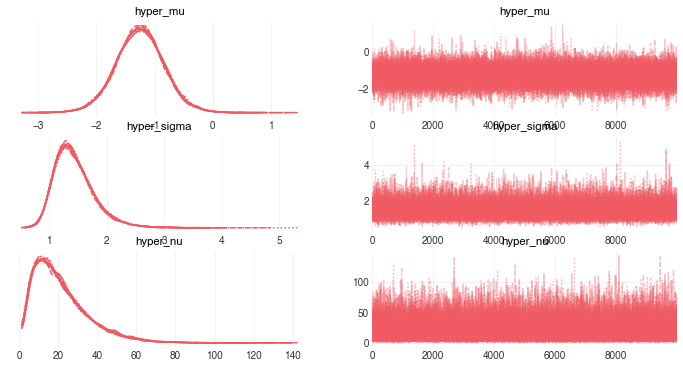

In [20]:
# sample our Bayesian model - looks like there are no divergences.
with model:
    trace = pm.sample(draws=10_000, tune=2_500, chains=10, cores=10)
    summary = az.summary(trace) 
    az.plot_trace(trace)      

In [21]:
# r_hat (Gelman-Rubin convergence diagnostic) of 1 looks good
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
hyper_mu,-1.257,0.417,-2.059,-0.485,0.001,0.001,84633.0,63773.0,1.0
hyper_sigma,1.438,0.353,0.858,2.107,0.001,0.001,75834.0,60222.0,1.0
hyper_nu,21.354,14.277,1.632,47.287,0.048,0.036,81016.0,60338.0,1.0


### Extract hyper_nu

In [22]:
# The mean for hyper_nu may not be the best measure of its central tendency,
# let's use a ***rough*** mode, given the kurtosis of this hyper-parameter. 
BINS = 2_500
nu = np.histogram(trace
                  .posterior
                  .stack(draws=("chain", "draw"))['hyper_nu'],
                  bins = BINS)
nu_binned = pd.Series(nu[0], nu[1][:-1])

# a simple smoother - helps find the mode accurately
smoother = pd.Series([1,2,3,4,4,4,4,4,3,2,1])
smoother = smoother / smoother.sum()
smoothed = (
    nu_binned
    .rolling(window=len(smoother),
             min_periods=len(smoother),
             center=True)
    .apply(func=lambda x: (x * smoother.values).sum())
)
nu_binned = smoothed.where(smoothed.notna(), other=nu_binned)

hyper_nu = nu_binned.idxmax()
print(f'Unadjusted maximum: {hyper_nu}')

# adjustment for bin middle
bin_width_adjust = (nu_binned.index[1] - nu_binned.index[0]) / 2.0
hyper_nu += bin_width_adjust
hyper_nu # adjusted for our bin width

Unadjusted maximum: 11.647820705792945


11.676229677808829

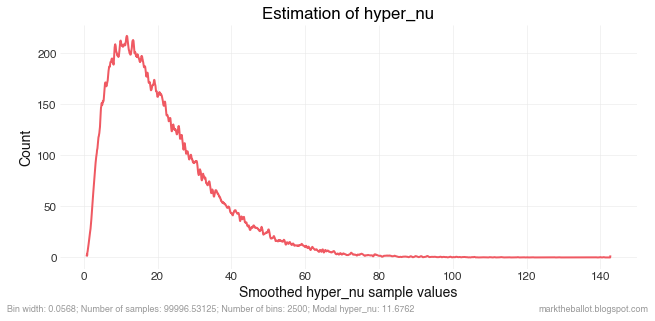

In [23]:
# Let's look at our hyper_nu samples as binned ...
ax = nu_binned.plot()
common.plot_finalise(ax, xlabel='Smoothed hyper_nu sample values', ylabel='Count',
                         lfooter=f'Bin width: {bin_width_adjust * 2:0.4f}; '
                                 f'Number of samples: {nu_binned.sum()}; '
                                 f'Number of bins: {len(nu_binned)}; '
                                 f'Modal hyper_nu: {hyper_nu:0.4f}', 
                         title='Estimation of hyper_nu')

## Watermark

In [24]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat Apr 30 2022

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.2.0

arviz     : 0.12.0
pymc      : 4.0.0b6
numpy     : 1.22.3
pandas    : 1.4.2
matplotlib: 3.5.1

Watermark: 2.3.0

